In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter1d
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Normalized RGB channels: R=(1093533,), G=(1093533,), B=(1093533,)
Calculated ExG index with shape: (1093533,)
Otsu's threshold for ExG: -0.1084
Number of white points: 293104 out of 1093533
Number of plant points: 496457 out of 1093533
Number of plant points after excluding white: 203353 out of 1093533
Filtered plant point cloud has 203353 points.
DBSCAN found 339 clusters and identified 57367 noise points.
Number of significant clusters (>= 10000 points): 3
Number of points in significant clusters: 128419 out of 203353
Plant point cloud after DBSCAN filtering has 128419 points.


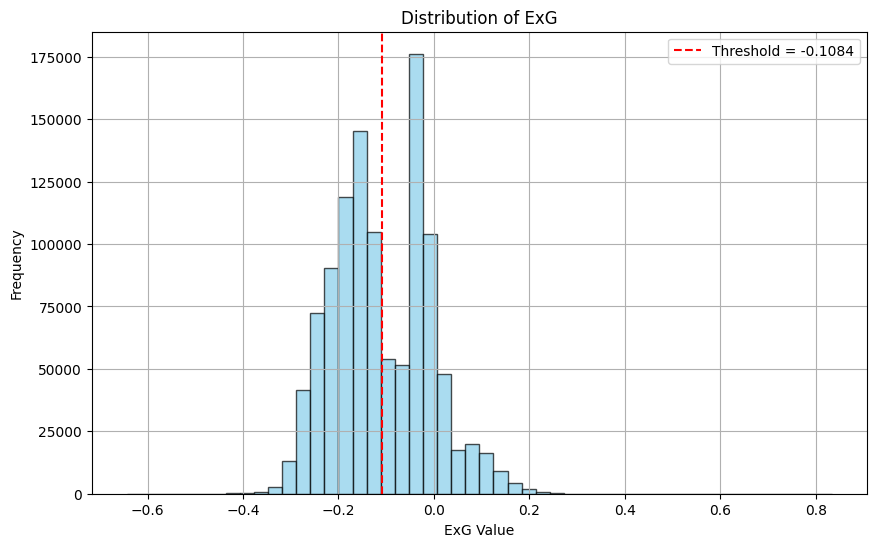

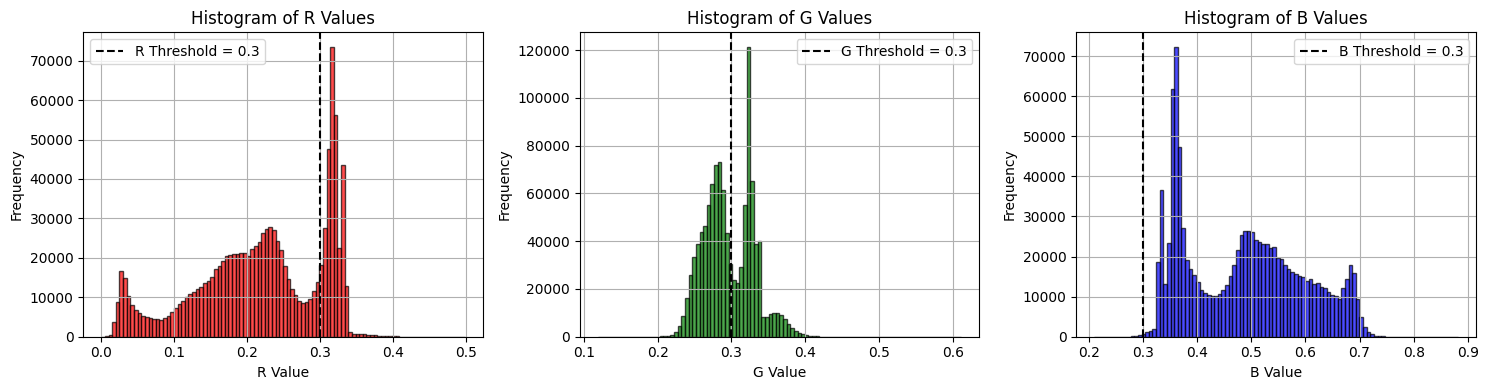

In [8]:
# Load point cloud
pcd = o3d.io.read_point_cloud(r"D:\USASK\USAK_Wheat_Reconstruction\unfiltered\Day_14\Wheat_Gladius\Wheat_Gladius_B6_2023-06-27-2029_fused.ply")
#pcd = o3d.io.read_point_cloud(r"D:\USASK\USAK_Wheat_Reconstruction\unfiltered\Day_35\Wheat_Alsen\Wheat_Alsen_F0_2023-07-22-1542_fused.ply")
if not pcd.has_colors():
    raise ValueError("Point cloud does not contain color information (RGB).")


# 2. Extract and Normalize RGB
colors = np.asarray(pcd.colors)  # Shape: (num_points, 3)
sum_rgb = np.sum(colors, axis=1) + 1e-6  # Avoid division by zero
r = colors[:, 0] / sum_rgb
g = colors[:, 1] / sum_rgb
b = colors[:, 2] / sum_rgb
print(f"Normalized RGB channels: R={r.shape}, G={g.shape}, B={b.shape}")

# 3. Calculate ExG
ExG = 2 * g - r - b
print(f"Calculated ExG index with shape: {ExG.shape}")

# 4. Apply Otsu's Thresholding
ExG_smooth = gaussian_filter1d(ExG, sigma=1)  # Optional smoothing
threshold = threshold_otsu(ExG_smooth)
print(f"Otsu's threshold for ExG: {threshold:.4f}")

# 5. Exclude White Points
white_threshold = 0.3  # Adjust based on data
white_mask = (r > white_threshold) & (g > white_threshold) & (b > white_threshold)
print(f"Number of white points: {np.sum(white_mask)} out of {len(white_mask)}")

# 6. Filter Plant Points Excluding White Points
plant_mask = ExG >= threshold
print(f"Number of plant points: {np.sum(plant_mask)} out of {len(plant_mask)}")

final_mask = plant_mask & (~white_mask)
print(f"Number of plant points after excluding white: {np.sum(final_mask)} out of {len(final_mask)}")

# 7. Select Points Based on Final Mask (Filtered Plant Points Only)
filtered_indices = np.where(final_mask)[0]
filtered_pcd = pcd.select_by_index(filtered_indices)
print(f"Filtered plant point cloud has {len(filtered_pcd.points)} points.")

# 8. Apply DBSCAN Clustering to the Filtered Plant Points
eps = 0.02  # Adjust based on data
min_samples = 20  # Adjust based on data

filtered_points = np.asarray(filtered_pcd.points)
scaler = StandardScaler()
filtered_points_scaled = scaler.fit_transform(filtered_points)

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(filtered_points_scaled)

unique_labels, counts = np.unique(labels, return_counts=True)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"DBSCAN found {n_clusters} clusters and identified {n_noise} noise points.")

# 9. (Optional) Visualize All Clusters Before Selecting Significant Ones
max_clusters = 20
colormap = cm.get_cmap("tab20", max_clusters)
colors_dbscan = np.zeros((len(labels), 3))
for label in unique_labels:
    if label == -1:
        # Noise in gray
        colors_dbscan[labels == label] = [0.5, 0.5, 0.5]
    else:
        # Assign distinct color
        colors_dbscan[labels == label] = colormap(label % max_clusters)[:3]

filtered_pcd.colors = o3d.utility.Vector3dVector(colors_dbscan)
o3d.visualization.draw_geometries(
    [filtered_pcd],
    window_name="DBSCAN Clustering: Different Colors for Each Cluster, Gray=Noise",
    width=800,
    height=600
)

# 9. Define a Minimum Cluster Size to Consider Significant
min_cluster_size = 10000  # Adjust based on your data
significant_clusters = unique_labels[(unique_labels != -1) & (counts >= min_cluster_size)]
print(f"Number of significant clusters (>= {min_cluster_size} points): {len(significant_clusters)}")

# 10. Create a Mask for Points in Significant Clusters (No Noise)
significant_mask = np.isin(labels, significant_clusters)
print(f"Number of points in significant clusters: {np.sum(significant_mask)} out of {len(significant_mask)}")

# 11. Extract Plant Points from Significant Clusters Only
plant_pcd = filtered_pcd.select_by_index(np.where(significant_mask)[0])
print(f"Plant point cloud after DBSCAN filtering has {len(plant_pcd.points)} points.")


# 9. Plot Histograms
def plot_histogram(data, title, xlabel, ylabel='Frequency', bins=50, threshold=None):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    if threshold is not None:
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
        plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

plot_histogram(ExG, "Distribution of ExG", "ExG Value", threshold=threshold)

# Plot RGB Histograms with White Threshold
def plot_rgb_histograms(r, g, b, white_threshold):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.hist(r, bins=100, color='red', edgecolor='black', alpha=0.7)
    plt.axvline(white_threshold, color='black', linestyle='--', label=f'R Threshold = {white_threshold}')
    plt.title('Histogram of R Values')
    plt.xlabel('R Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.hist(g, bins=100, color='green', edgecolor='black', alpha=0.7)
    plt.axvline(white_threshold, color='black', linestyle='--', label=f'G Threshold = {white_threshold}')
    plt.title('Histogram of G Values')
    plt.xlabel('G Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.hist(b, bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.axvline(white_threshold, color='black', linestyle='--', label=f'B Threshold = {white_threshold}')
    plt.title('Histogram of B Values')
    plt.xlabel('B Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_rgb_histograms(r, g, b, white_threshold)


In [9]:

# Assign green color to all plant points
plant_colors_final = np.tile([0, 1, 0], (len(plant_pcd.points), 1))
plant_pcd.colors = o3d.utility.Vector3dVector(plant_colors_final)

# 13. Visualize Only the Final Plant Points (No Background, No Noise)
o3d.visualization.draw_geometries(
    [plant_pcd],
    window_name="Final Filtered Plant Point Cloud (Green=Plant)",
    width=800,
    height=600
)


# ===== Map Back to Original Point Cloud =====

# We know that:
# - 'final_mask' is a boolean mask for the original point cloud indicating which points are initially considered "plant" before clustering.
# - 'filtered_pcd' corresponds to points where 'final_mask' is True.
# - 'significant_mask' corresponds to a subset of 'filtered_pcd'.

# Get the indices of the significant plant points in the original point cloud
significant_indices_filtered = np.where(significant_mask)[0]
significant_indices_original = filtered_indices[significant_indices_filtered]

# Create a label array for the entire original point cloud
# Initialize all labels to 0 (non-plant)
labels_array = np.zeros(len(pcd.points), dtype=int)
# Mark plant points as 1
labels_array[significant_indices_original] = 1

# ===== Visualize Labels on the Original Point Cloud =====

# Assign colors based on labels: plant=1 => green, non-plant=0 => red
colors_final = np.zeros((len(pcd.points), 3))
colors_final[labels_array == 1] = [0, 1, 0]  # Green for plant
colors_final[labels_array == 0] = [1, 0, 0]  # Red for non-plant

pcd.colors = o3d.utility.Vector3dVector(colors_final)

# Visualize the original point cloud with plant=green and non-plant=red
o3d.visualization.draw_geometries(
    [pcd],
    window_name="Original Point Cloud with Labels: Green=Plant (1), Red=Non-Plant (0)",
    width=800,
    height=600
)

# Save the labeled point cloud if desired
o3d.io.write_point_cloud("original_point_cloud_with_labels.ply", pcd)
print("Original point cloud with labels saved as 'original_point_cloud_with_labels.ply'.")

# You can also save the labels_array separately for future reference
np.save("point_cloud_labels.npy", labels_array)
print("Labels array saved as 'point_cloud_labels.npy'.")

Original point cloud with labels saved as 'original_point_cloud_with_labels.ply'.
Labels array saved as 'point_cloud_labels.npy'.
